In [ ]:
# Transfer Learning with VGG16

In [ ]:
import numpy as np
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
# You will need to load the images.
# Download the Chessman image dataset by Nitesh Yadav from Kaggle: 
# https://www.kaggle.com/niteshfre/chessman-image-dataset
# Either get the file from Kaggle API, manually upload the archive.zip file,
# Or mount Google Drive.

In [ ]:
#!unzip archive.zip

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
labelDictionary = {'Pawn': 0, 'Knight': 1, 'Bishop': 2, 'Rook': 3, 'Queen': 4, 'King': 5}
class_names = ['Pawn', 'Knight', 'Bishop', 'Rook', 'Queen', 'King']

In [ ]:
# Change basepath, depending on how you uploaded your data.
basepath = "Chessman-image-dataset/Chess"

images=[]
labels=[]

# Loop through each folder in the directory
for folder in os.listdir(basepath):
  label = folder
  # Loop through each file in the directory
  for file in os.listdir(basepath+ "/" + folder):
    if 'jpg' in file:
      new_img = cv2.resize(cv2.imread(basepath+ "//" + folder + "//" + file), (224,224))
      images.append(new_img)
      labels.append(labelDictionary[label])

images = np.array(images)
labels = np.array(labels)

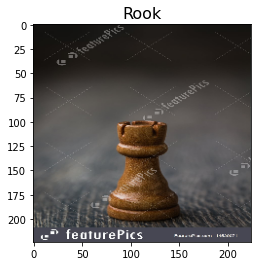

In [ ]:
# Display one of the image.
plt.imshow(cv2.cvtColor(images[21], cv2.COLOR_BGR2RGB))
plt.title(class_names[labels[21]], fontsize = 16)
plt.show()

In [ ]:
# Shuffle our data
(images, labels) = shuffle(images, labels)

In [ ]:
# Split our dataset: 60% training, 20% validation, and 20% testing.
x_train, x_remainder, y_train, y_remainder = train_test_split(images, labels, train_size=0.6)
x_valid, x_test, y_valid, y_test = train_test_split(x_remainder, y_remainder, test_size=0.5)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(279, 224, 224, 3)
(279,)
(93, 224, 224, 3)
(93,)
(93, 224, 224, 3)
(93,)


In [ ]:
# Use random data augmentation to artificially introduce sample diversity
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
              
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_generator = train_datagen.flow(x_valid, y_valid, batch_size=8, seed=1) 

In [ ]:
# Instantiate the VGG16 model
base_model = keras.applications.VGG16(weights='imagenet', include_top=False, 
                             input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
NUM_CLASSES = 6

# Freeze layers and add new trainable layers
base_model.trainable = False
out = base_model.output
out = Flatten()(out)
out = Dense(4096, activation="relu")(out)
out = Dropout(0.3)(out)
out = Dense(4096, activation='relu')(out)
out = Dropout(0.3)(out)
out = Dense(500, activation='relu')(out)
out = Dropout(0.3)(out)
outputs = Dense(NUM_CLASSES, activation='softmax')(out)

model = tf.keras.Model(base_model.input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
f_model = model.fit(train_generator,
                    steps_per_epoch=len(x_train) // 32,
                    validation_data=valid_generator,
                    epochs=35, verbose=1)

Epoch 1/35
8/8 [==============================] - 13s 1s/step - loss: 15.9662 - accuracy: 0.1660 - val_loss: 2.2705 - val_accuracy: 0.1613
Epoch 2/35
8/8 [==============================] - 4s 478ms/step - loss: 2.2032 - accuracy: 0.1903 - val_loss: 1.9104 - val_accuracy: 0.1613
Epoch 3/35
8/8 [==============================] - 4s 477ms/step - loss: 1.8963 - accuracy: 0.2024 - val_loss: 1.7770 - val_accuracy: 0.2258
Epoch 4/35
8/8 [==============================] - 4s 484ms/step - loss: 1.8153 - accuracy: 0.2186 - val_loss: 1.7515 - val_accuracy: 0.2688
Epoch 5/35
8/8 [==============================] - 4s 482ms/step - loss: 1.6635 - accuracy: 0.3360 - val_loss: 1.5110 - val_accuracy: 0.4409
Epoch 6/35
8/8 [==============================] - 4s 486ms/step - loss: 1.4376 - accuracy: 0.4413 - val_loss: 1.4721 - val_accuracy: 0.4516
Epoch 7/35
8/8 [==============================] - 4s 492ms/step - loss: 1.3546 - accuracy: 0.4414 - val_loss: 1.1061 - val_accuracy: 0.5699
Epoch 8/35
8/8 [=====

In [ ]:
# Scale the testing set
x_test_scaled = x_test/255.

In [ ]:
# Find the total loss and accuracy of the testing set before unfreezing
score = model.evaluate(x_test_scaled, y_test)
print("Total loss on Testing Set: ", score[0])
print("Accuracy of Testing Set: ", score[1])
result = model.predict(x_test_scaled)

3/3 [==============================] - 3s 1s/step - loss: 0.5427 - accuracy: 0.7419
Total loss on Testing Set:  0.5427349805831909
Accuracy of Testing Set:  0.7419354915618896


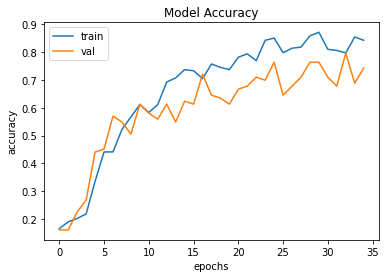

In [ ]:
# Plot Model Accuracy before unfreezing
plt.plot(f_model.history['accuracy'], label='train')
plt.plot(f_model.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

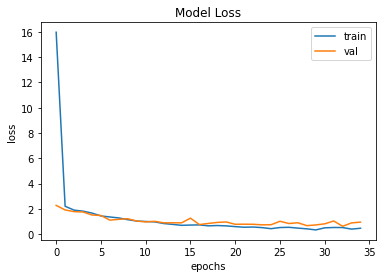

In [ ]:
# Plot Model Loss before unfreezing
plt.plot(f_model.history['loss'], label = 'train')
plt.plot(f_model.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
# Unfreeze the base model
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Recompile model with low learning rate
model.compile(Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
uf_model = model.fit(train_generator,
                    steps_per_epoch=len(x_train) // 32,
                    validation_data=valid_generator,
                    epochs=15, verbose=1)

Epoch 1/15
8/8 [==============================] - 7s 628ms/step - loss: 0.3681 - accuracy: 0.8785 - val_loss: 0.6489 - val_accuracy: 0.7419
Epoch 2/15
8/8 [==============================] - 5s 564ms/step - loss: 0.2576 - accuracy: 0.8988 - val_loss: 0.7271 - val_accuracy: 0.7419
Epoch 3/15
8/8 [==============================] - 4s 495ms/step - loss: 0.3398 - accuracy: 0.8907 - val_loss: 1.0937 - val_accuracy: 0.7419
Epoch 4/15
8/8 [==============================] - 4s 485ms/step - loss: 0.2314 - accuracy: 0.9150 - val_loss: 0.6290 - val_accuracy: 0.7634
Epoch 5/15
8/8 [==============================] - 4s 487ms/step - loss: 0.3253 - accuracy: 0.8907 - val_loss: 0.7487 - val_accuracy: 0.7957
Epoch 6/15
8/8 [==============================] - 4s 496ms/step - loss: 0.3436 - accuracy: 0.8785 - val_loss: 0.7046 - val_accuracy: 0.7312
Epoch 7/15
8/8 [==============================] - 4s 493ms/step - loss: 0.2247 - accuracy: 0.9069 - val_loss: 0.7042 - val_accuracy: 0.7957
Epoch 8/15
8/8 [====

In [ ]:
# Find the total loss and accuracy of the testing set after unfreezing
score = model.evaluate(x_test_scaled, y_test)
print("Total loss on Testing Set: ", score[0])
print("Accuracy of Testing Set: ", score[1])
result = model.predict(x_test_scaled)

3/3 [==============================] - 0s 67ms/step - loss: 0.4578 - accuracy: 0.8710
Total loss on Testing Set:  0.4578090310096741
Accuracy of Testing Set:  0.8709677457809448


In [ ]:
num = len(uf_model.history['accuracy'])
num_two = len(uf_model.history['val_accuracy'])

# Append accuracy data from new model to the old model
for i in range(num):
  f_model.history['accuracy'].append(uf_model.history['accuracy'][i])

for i in range(num_two):
  f_model.history['val_accuracy'].append(uf_model.history['val_accuracy'][i])

In [ ]:
num = len(uf_model.history['loss'])
num_two = len(uf_model.history['val_loss'])

# Append loss data from new model to the old model
for i in range(num):
  f_model.history['loss'].append(uf_model.history['loss'][i])

for i in range(num_two):
  f_model.history['val_loss'].append(uf_model.history['val_loss'][i])

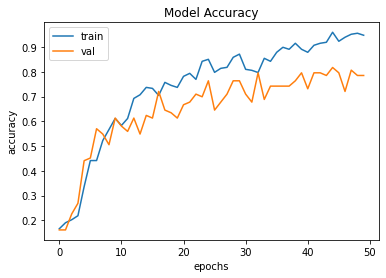

In [ ]:
# Plot Model Accuracy after unfreezing
plt.plot(f_model.history['accuracy'], label='train')
plt.plot(f_model.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

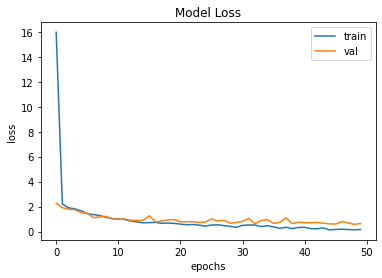

In [ ]:
# Plot Model Loss after unfreezing
plt.plot(f_model.history['loss'], label = 'train')
plt.plot(f_model.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
# Get the indices. Then, print out weighted precision, recall, and F1 scores
formatted_results = []
for i in range(len(result)):
  formatted_results.append(np.argmax(result[i]))

print("Weighted Precision Score: " + str(precision_score(y_test, formatted_results, average='weighted')))
print("Weighted Recall Score: " + str(recall_score(y_test, formatted_results, average='weighted')))
print("Weighted F1 Score: " + str(f1_score(y_test, formatted_results, average='weighted')))

Weighted Precision Score: 0.8770340980967167
Weighted Recall Score: 0.8709677419354839
Weighted F1 Score: 0.8660402113311182


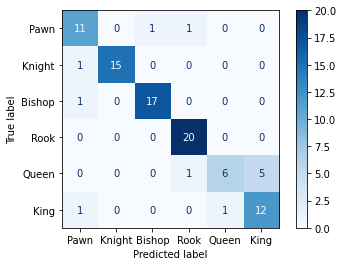

In [ ]:
# Plot and display confusion matrix
cm = confusion_matrix(y_test, formatted_results)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmDisplay.plot(cmap='Blues')
plt.show()

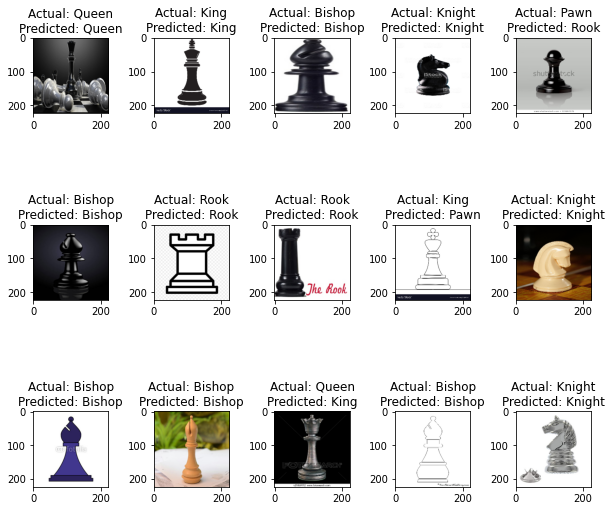

In [ ]:
# Display actual and predicted data of a few data from testing set
n_rows = 3
n_cols = 5
index = 0;
plt.figure(figsize=(10, 10))
for row in range(n_rows):
    for col in range(n_cols):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(cv2.cvtColor(x_test[index], cv2.COLOR_BGR2RGB))
        plt.title("Actual: " + str(class_names[y_test[index]]) + "\nPredicted: " + str(class_names[np.argmax(result[index])]), fontsize=12)
        index += 1
plt.subplots_adjust(wspace=0.6, hspace=0.1)
plt.show()